In [1]:
import torch
from torch import nn
import torch.nn.functional as f
import torchvision

import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {
    "LR": 1e-5,
    "N_BATCHS": 32,
    "N_EPOCHS": 50,
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device type:", device)

Device type: cuda


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(
    root="./datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=params["N_BATCHS"], shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=params["N_BATCHS"], shuffle=True,
)

In [3]:
class AE(nn.Module):
    def __init__(self,
        latent_space_size=4,
    ) -> None:
        super(AE, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=(5,5), padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(128*6*6, latent_space_size),
        )
        self.deconv_0 = nn.Sequential(
            nn.Linear(latent_space_size, 128*6*6),
            # nn.BatchNorm2d(),
            nn.ELU(),
        )
        self.deconv_1 = nn.Sequential(
            nn.ConvTranspose2d(128, 46, kernel_size=(5,5), padding=1, stride=2),
            nn.BatchNorm2d(46),
            nn.ELU(),
            nn.ConvTranspose2d(46, 1, kernel_size=(6,6), padding=1, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        z = self.conv(x)
        z = self.deconv_0(z).view(x.size(0), 128, 6, 6)
        x_hat = self.deconv_1(z).view(x.size(0), 1, 28, 28)
        return x_hat

In [4]:
model = AE().to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=params["LR"])

train_history, test_history = [], []

for epoch in range(params["N_EPOCHS"]):
    train_loss = 0.
    test_loss = 0.
    for X, _ in train_loader:
        X = X.to(device)
        X_hat = model(X)
        loss = loss_fn(X_hat, X)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()

    with torch.no_grad():
        for X, _ in test_loader:
            X = X.to(device)
            X_hat = model(X)
            loss = loss_fn(X_hat, X)
            test_loss += loss.item()

    train_loss /= len(train_loader)            
    test_loss /= len(test_loader)
    print(f"> {epoch+1}/{params['N_EPOCHS']} | train_loss = {train_loss:.6f}; eval_loss = {test_loss:.6f}")
    train_history.append(train_loss)
    test_history.append(test_loss)

> 1/50 | train_loss = 0.823481; eval_loss = 0.721738
> 2/50 | train_loss = 0.693009; eval_loss = 0.678787
> 3/50 | train_loss = 0.666879; eval_loss = 0.663649
> 4/50 | train_loss = 0.655305; eval_loss = 0.655052
> 5/50 | train_loss = 0.647950; eval_loss = 0.648671
> 6/50 | train_loss = 0.642514; eval_loss = 0.643978
> 7/50 | train_loss = 0.638580; eval_loss = 0.640334
> 8/50 | train_loss = 0.635352; eval_loss = 0.637924
> 9/50 | train_loss = 0.633194; eval_loss = 0.635947
> 10/50 | train_loss = 0.630839; eval_loss = 0.633438
> 11/50 | train_loss = 0.628860; eval_loss = 0.632149
> 12/50 | train_loss = 0.627371; eval_loss = 0.630335
> 13/50 | train_loss = 0.625871; eval_loss = 0.629103
> 14/50 | train_loss = 0.624554; eval_loss = 0.627742
> 15/50 | train_loss = 0.623431; eval_loss = 0.626919
> 16/50 | train_loss = 0.622216; eval_loss = 0.625359
> 17/50 | train_loss = 0.620669; eval_loss = 0.624090
> 18/50 | train_loss = 0.619560; eval_loss = 0.622998
> 19/50 | train_loss = 0.617944; eval

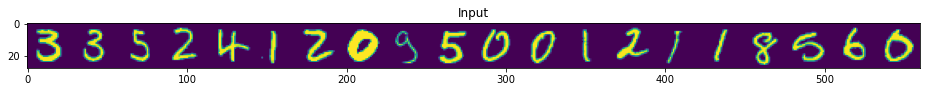

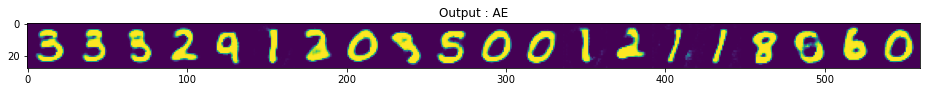

In [44]:
SAMPLE = [random.choice(test_dataset.data) for _ in range(20)]
RANDOM = torch.randn((1,1,28,28))
with torch.no_grad():
    plt.figure(figsize=(16,16))
    plt.title("Input")
    plt.imshow(np.concatenate(SAMPLE, axis=1))

    plt.figure(figsize=(16,16))
    plt.title("Output : AE")
    plt.imshow(np.concatenate([model(x.to(device).float().view(1, 1, 28, 28)).cpu().numpy().reshape((28,28)) for x in SAMPLE], axis=1))

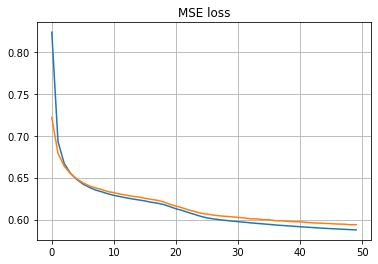

In [29]:
# plt.figure(figsize=(16,16))
plt.title("MSE loss")
plt.grid()
plt.plot(train_history, label="train loss")
plt.plot(test_history, label="test loss")